# Imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy
import itertools
import copy

# Finite differences method

Here we want to solve the Laplace equation $\nabla^2 \phi = 0$ for different configurations of static boundary conditions

## With the Jacobi method

We build some boundary conditions

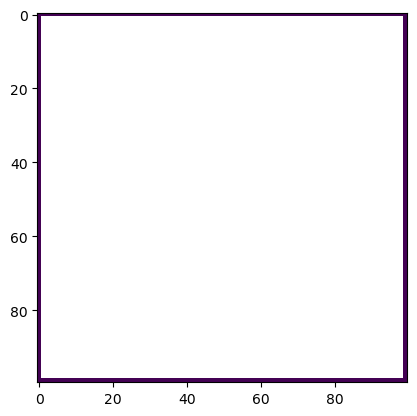

In [2]:
Nside = 100
boundaries = np.ones((Nside, Nside))*np.nan
for i in range(Nside):
    for j in range(Nside):
        rules = [
            i==0,
            i==Nside-1,
            j==0,
            j==Nside-1,
        ]
        
        if(any(rules)):
            boundaries[i,j] = 0.
plt.imshow(boundaries)
plt.show()

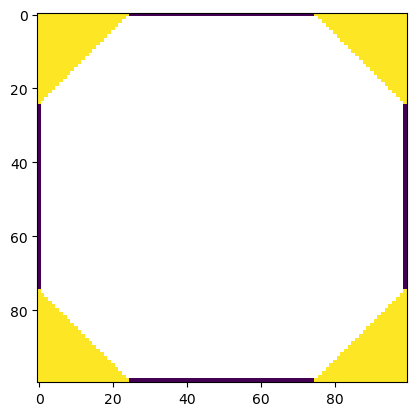

In [3]:
for i in range(Nside):
    for j in range(Nside):
        rules = [
            i+j < Nside/4,
            2*(Nside-1)-i-j < Nside/4,
            (Nside-1)-i+j < Nside/4,
            (Nside-1)+i-j < Nside/4,
        ]
        if(any(rules)):
            boundaries[i,j] = 1.
plt.imshow(boundaries)
plt.show()

Solve with finite difference method, implemented here using the Jacobi method

In [4]:
max_iter = 100000
tol = 1.e-3
field = np.zeros_like(boundaries)

for t in range(max_iter):
    ofield = field.copy()
    field[1:-1, 1:-1] = 0.25 * (ofield[2:,1:-1] + ofield[:-2,1:-1] + ofield[1:-1,2:] + ofield[1:-1,:-2])
    field[boundaries == boundaries] = boundaries[boundaries == boundaries]
    if(np.all(np.abs(ofield-field) < tol*np.abs(field+ofield))):
        print("relative precision met in", t, "iterations")
        break
    if(np.all(np.abs(ofield-field) < tol*1.e-3)):
        print("absolute precision met in", t, "iterations")
        break

absolute precision met in  10747 iterations


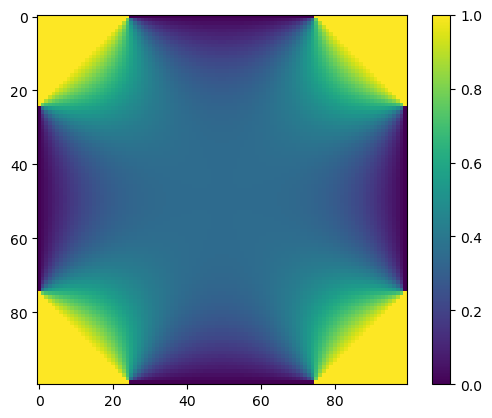

In [5]:
plt.imshow(field)
plt.colorbar()

## With overrelaxation

We build a different set of boundary conditions

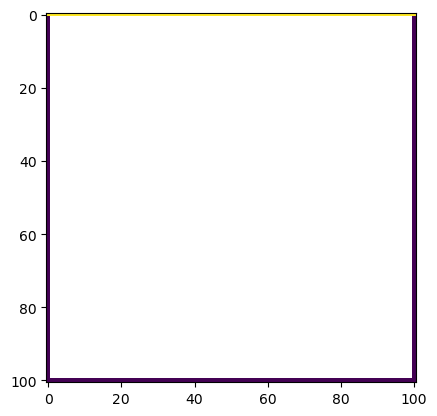

In [6]:
Nside = 101
boundaries = np.ones((Nside, Nside))*np.nan
for i in range(Nside):
    for j in range(Nside):
        rules = [
            i==Nside-1,
            j==0,
            j==Nside-1,
        ]
        
        if(any(rules)):
            boundaries[i,j] = 0.
            
for i in range(Nside):
    for j in range(Nside):
        rules = [
            i==0
        ]
        if(any(rules)):
            boundaries[i,j] = 1.
plt.imshow(boundaries)
plt.show()

We solve it again with Jacobi, to have a comparison

In [7]:
max_iter = 100000
tol = 1.e-3
field = np.zeros_like(boundaries)

for t in range(max_iter):
    ofield = field.copy()
    field[1:-1, 1:-1] = 0.25 * (ofield[2:,1:-1] + ofield[:-2,1:-1] + ofield[1:-1,2:] + ofield[1:-1,:-2])
    field[boundaries == boundaries] = boundaries[boundaries == boundaries]
    if(np.all(np.abs(ofield-field) < tol*np.abs(field+ofield))):
        print("relative precision met in", t, "iterations")
        break
    if(np.all(np.abs(ofield-field) < tol*1.e-3)):
        print("absolute precision met in", t, "iterations")
        break

absolute precision met in  10736 iterations


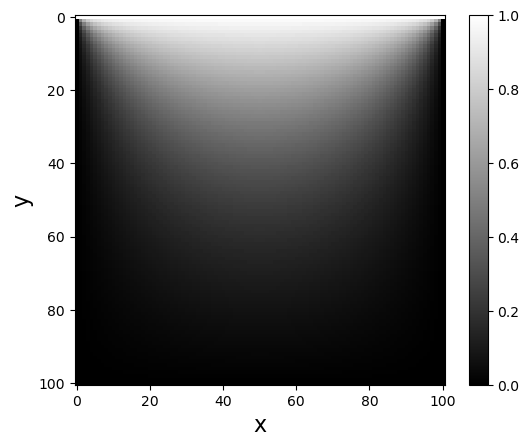

In [8]:
import matplotlib.pyplot as plt
from pylab import imshow

plt.imshow(field,cmap='gray')
plt.colorbar()
plt.xlabel('x',size=16)
plt.ylabel('y',size=16)
plt.show()

Remember Jacobi vs relaxation method? Why the following doesn't work?

In [9]:
max_iter = 100 #We stop the evaluation after few iteration, but you are free to increase max_iter: at some point you will incur in numerical instabilities
tol = 1.e-3
field = np.zeros_like(boundaries)
omega = 0.9

for t in range(max_iter):
    ofield = field.copy()
    field[1:-1, 1:-1] = 0.25 * (1+omega) * (ofield[2:,1:-1] + ofield[:-2,1:-1] + ofield[1:-1,2:] + ofield[1:-1,:-2]) - omega*ofield[1:-1, 1:-1]
    field[boundaries == boundaries] = boundaries[boundaries == boundaries]
    if(np.all(np.abs(ofield-field) < tol*np.abs(field+ofield))):
        print("relative precision met in", t, "iterations")
        break
    if(np.all(np.abs(ofield-field) < tol*1.e-3)):
        print("absolute precision met in", t, "iterations")
        break

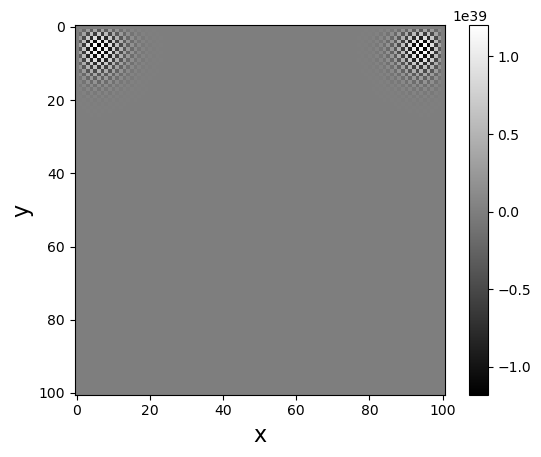

In [10]:
import matplotlib.pyplot as plt
from pylab import imshow

plt.imshow(field,cmap='gray')
plt.colorbar()
plt.xlabel('x',size=16)
plt.ylabel('y',size=16)
plt.show()

And now we use overrelaxation

In [11]:
max_iter = 100000
tol = 1.e-3
field = np.zeros_like(boundaries)
omega = 0.9

field[boundaries == boundaries] = boundaries[boundaries == boundaries]

for t in range(max_iter):
    delta = 0
    for i in range(1,len(field)-1):
        for j in range(1,len(field[0])-1):
            ofield = field[i,j]
            field[i,j] = 0.25 * (1+omega) * (field[i-1,j] + field[i+1,j] + field[i,j-1] + field[i,j+1]) - omega*field[i,j]
            delta += (field[i,j]-ofield)**2
    field[boundaries == boundaries] = boundaries[boundaries == boundaries]
    if(np.sqrt(delta) < tol):
        print("absolute precision met in ", t, "iterations")
        break

absolute precision met in  276 iterations


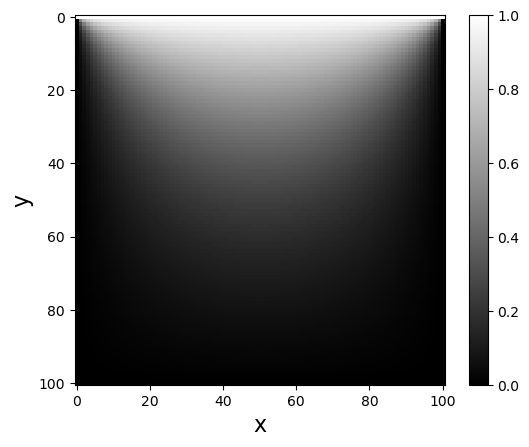

In [12]:
import matplotlib.pyplot as plt
from pylab import imshow

plt.imshow(field,cmap='gray')
plt.colorbar()
plt.xlabel('x',size=16)
plt.ylabel('y',size=16)
plt.show()

# Forward Time Centered Space

## Diffusion of heat in the Earth crust

We assume that the temperature of the crust on the Earth surface changes according to $T(z=0, t) = 10°$C$\ +\ 12°$C $ \sin(2\pi t/\text{yr})$, while the temperature 20 meters underground is at a constant 11°C.\
We also approximate the thermal diffusivity to be $D = 0.1 \text{m}^2 \text{day}^{-1}$.\
Start assuming a temperature profile which is at a constant $10°C$, except for the two boundaries. 

We evolve the system for ten years. With our choice of initial conditions, it will take a few years for the crust to thermalize.\
You may incur into numerical instabilities if the time steps are too large. The values used here have been tuned to avoid that.\
Notice that here we are not managing the errors, but in principle you may want to do that.

In [13]:
D = 0.1 * 365
Ns = 300
a = 20 / Ns

Nt = 300000
times = np.linspace(0, 10, Nt)
h = 10 / Nt

T20 = 273.15 + 11
T0 = 273.15 + 10 + 12*np.sin(2.*np.pi*times[0])

temperatures = [np.ones(Ns) * (273.15 + 10)]
temperatures[0][0] = T20
temperatures[0][-1] = T0

for it in range(1, Nt-1):
    T0 = 273.15 + 10 + 12*np.sin(2.*np.pi*times[it])
    temp = np.ones(Ns) * (273.15 + 10)
    temp[0] = T20
    temp[-1] = T0

    prev_temp = temperatures[it-1]
    temp[1:-1] = prev_temp[1:-1] + h*(D/a**2)*(prev_temp[2:] + prev_temp[:-2] - 2*prev_temp[1:-1])
    
    temperatures.append(temp)
    
temperatures = np.array(temperatures)

We can plot the solution in the first few days to see how the system start to stabilize

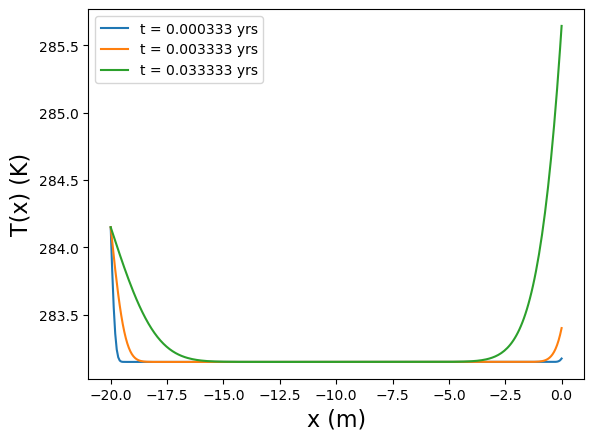

In [14]:
x = np.linspace(-20,0,Ns)

for i in [10, 100, 1000]:
    plt.plot(x,temperatures[i,:],label='t = %f yrs' %times[i])
plt.legend()
plt.xlabel('x (m)',size = 16)
plt.ylabel('T(x) (K)',size= 16)
plt.show()

We then want to plot the solution every approximately 3 months in the tenth year.
Notice that by then, the system has approximately become periodic with a period of 1 year, as expected.

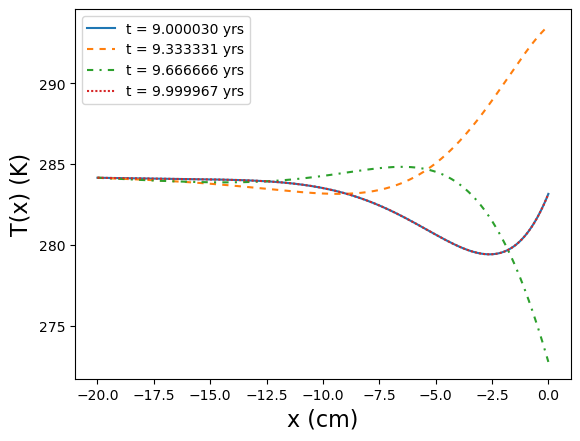

In [15]:
x = np.linspace(-20,0,Ns)

for i, d in zip([int(Nt*0.9), int(Nt*0.933333), int(Nt*0.966666), int(Nt)-2], [[], [3,3], [3,3,1,3], [1,1]]):
    plt.plot(x,temperatures[i,:],label='t = %f yrs' %times[i], dashes=d)
plt.legend()
plt.xlabel('x (cm)',size = 16)
plt.ylabel('T(x) (K)',size= 16)
plt.show()